In [2]:
import dash 
from dash import Dash,dcc,html,callback,Input,Output, Patch, clientside_callback, callback
import plotly.io as pio
from dash_bootstrap_templates import load_figure_template

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import Figure as fig
import pages as pag
import Functions_dash as Fun

In [5]:
import pandas as pd
import geopandas 
data= pd.read_csv("accidents-velos_clean.csv",low_memory=False)
pistes_cyclables= geopandas.read_file("pistes_cyclables.geojson")

In [19]:
com = data[['com','com_name','reg','dep','region_name','dep_name',]]
com=com.drop_duplicates(subset='com')
pc=pd.merge(pistes_cyclables, com, left_on='code_com_d', right_on='com', how='left')
pc.dropna(subset=['dep', 'reg'], inplace=True)

In [67]:
#pistes_par_reg=pc.groupby(["reg","region_name"]).size().reset_index(name="nombre_pistes_cyclables")
pistes_par_dep=pc.groupby(["dep","dep_name","reg","region_name"]).size().reset_index(name="nombre_pistes_cyclables")
pistes_par_com=pc.groupby(["com","com_name"]).size().reset_index(name="nombre_pistes_cyclables")
pistes_par_reg=pistes_par_reg.sort_values(by = "nombre_pistes_cyclables",ascending=False)
pistes_par_dep=pistes_par_dep.sort_values(by = "nombre_pistes_cyclables",ascending=False)
pistes_par_com=pistes_par_com.sort_values(by = "nombre_pistes_cyclables",ascending=False)
pistes_par_dep

,dep,dep_name,reg,region_name,nombre_pistes_cyclables
59,59,Nord,32.0,Hauts-de-France,15730
44,44,Loire-Atlantique,52.0,Pays de la Loire,10900
75,75,Paris,11.0,Île-de-France,10482
69,69,Rhône,84.0,Auvergne-Rhône-Alpes,10248
33,33,Gironde,75.0,Nouvelle-Aquitaine,9738
...,...,...,...,...,...
32,32,Gers,76.0,Occitanie,176
48,48,Lozère,76.0,Occitanie,171
28,2A,Corse-du-Sud,94.0,Corse,73
29,2B,Haute-Corse,94.0,Corse,63


## ratio

In [3]:
pistes_par_com=pd.read_csv("pistes_com.csv")
pistes_par_dep=pd.read_csv("pistes_dep.csv")
pistes_par_reg=pd.read_csv("pistes_reg.csv")


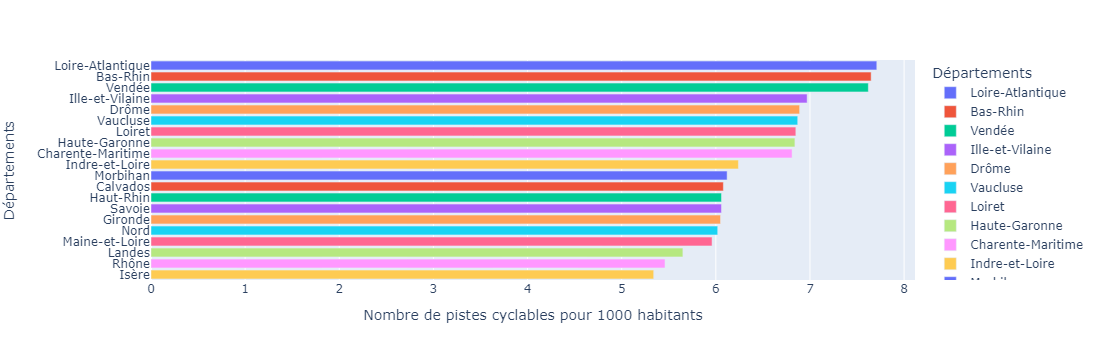

In [5]:
def bar_popup(zone_geo,indicateur):
    if indicateur == "qte":
        if zone_geo == "reg":
            fig = px.bar(pistes_par_reg, y="region_name", x="nombre_pistes_cyclables", color="region_name")
            fig.update_layout(yaxis_title="Regions",legend_title_text="Regions")
        elif zone_geo == "dep":
            top_20_dep = pistes_par_dep.head(20)
            fig = px.bar(top_20_dep, y="dep_name", x="nombre_pistes_cyclables", color="dep_name")
            fig.update_layout(yaxis=dict(tickmode='linear', dtick=1),yaxis_title="Départements",legend_title_text="Départements")
        else:
            top_20_com = pistes_par_com.head(20)
            fig = px.bar(top_20_com, y="com_name", x="nombre_pistes_cyclables", color="com_name")
            fig.update_layout(yaxis=dict(tickmode='linear', dtick=1),yaxis_title="Communes",legend_title_text="Communes")

    else:
        if zone_geo == "reg":
            fig = px.bar(pistes_par_reg, y="region_name", x="ratio", color="region_name")
            fig.update_layout(yaxis_title="Regions",legend_title_text="Regions")
        elif zone_geo == "dep":
            top_20_dep = pistes_par_dep.sort_values(by="ratio", ascending=False).head(20)
            fig = px.bar(top_20_dep, y="dep_name", x="ratio", color="dep_name")
            fig.update_layout(yaxis=dict(tickmode='linear', dtick=1),yaxis_title="Départements",legend_title_text="Départements")
        else:
            top_20_com = pistes_par_com.sort_values(by="ratio", ascending=False).head(20)
            fig = px.bar(top_20_com, y="com_name", x="nombre_pistes_cyclables", color="com_name")
            fig.update_layout(yaxis=dict(tickmode='linear', dtick=1),yaxis_title="Communes",legend_title_text="Communes")
        fig.update_layout(xaxis_title=" Nombre de pistes cyclables pour 1000 habitants")


    return fig

bar_popup("dep","raio")


# Notre appli

In [1]:
import dash
import dash_bootstrap_components as dbc
from dash import Dash,dcc,html,callback,Input,Output, Patch, clientside_callback, callback
import plotly.io as pio
from dash_bootstrap_templates import load_figure_template
import pandas as pd 
import plotly.express as px
import Functions_dash as Fun
import Figure as fig
import pages as pag
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

app = dash.Dash(
    external_stylesheets=[dbc.themes.BOOTSTRAP, dbc.icons.FONT_AWESOME, "assets/styles.css"],suppress_callback_exceptions=True
)

# Bar noir en haut de page
navbar = dbc.NavbarSimple(
    children=[
        dbc.Button("Menu", outline=True, color="secondary", className="mr-1", id="btn_sidebar"), # Bouton pour le menu
        dbc.Popover(
                    "CLiquez pour ranger/sortir le sidebar",
                    target='btn_sidebar',
                    trigger="hover",
                    placement = "bottom"
                 ),
        dcc.Dropdown(
                    id='zone-data-filter',
                    options=[{"label":"Nationale","value":'all'},
                             {"label":"Régional","value":'reg'},
                             {"label":"Départemental","value":'dep'}
                            ],
                    value="all",
                    searchable=False,
                    clearable=False,
                    ),
         dbc.Popover(
                    "Choix de zone géographique",
                    target='zone-data-filter',
                    trigger="hover",
                    placement = "bottom"
                    ),
        dcc.Dropdown(
                    id='zone-selection',
                    options=[],
                    #style={'display': 'none'},
                    value=None,
                    searchable=False,
                    clearable=False,
                    placeholder=""
                    )
    ],
    brand="",
    brand_href="#",
    color="dark",
    dark=True,
    fluid=True,
    links_left= True,
)


submenu_1 = [
    html.Li(
        # use Row and Col components to position the chevrons
        dbc.Row(
            [
                dbc.Col("Visualisations"),
                dbc.Col(
                    html.I(className="fas fa-chevron-right me-3"),
                    width="auto",
                ),
            ],
            className="my-1",
        ),
        style={"cursor": "pointer"},
        id="submenu-1",
    ),
    # we use the Collapse component to hide and reveal the navigation links
    dbc.Collapse(
        [
            dbc.NavLink("Evolution temporelle", href="/page-1/1"),
            dbc.NavLink("Caractéristiques des accidents", href="/page-1/2"),
        ],
        id="submenu-1-collapse",
    ),
]

submenu_2 = [
    html.Li(
        dbc.Row(
            [
                dbc.Col("Cartes interactives"),
                dbc.Col(
                    html.I(className="fas fa-chevron-right me-3"),
                    width="auto",
                ),
            ],
            className="my-1",
        ),
        style={"cursor": "pointer"},
        id="submenu-2",
    ),
    dbc.Collapse(
        [
            dbc.NavLink("Carte de la France", href="/page-map"),
            dbc.NavLink("Carte Regions/Départements", href="/page-2/2"),
        ],
        id="submenu-2-collapse",
    ),
]


sidebar = html.Div(
    [
        html.H2("DashBike", className="display-4"),
        html.Hr(),
        html.Img(src = Image.open("accident_bike.png"),style={"width": "60%",
                                                             "margin-bottom": '10%'}),
        html.P(
            "Vous trouverez ici les différentes pages du dashboard", className="lead"
        ),
        dbc.Nav(submenu_1 + submenu_2, vertical=True,pills=True),
        html.Img(src=Image.open("roue.png"),style={"width": "60%",
                                                  "margin-top": '100%'}),
    ],
    style=fig.SIDEBAR_STYLE,
    id="sidebar",
)


content = html.Div(id="page-content", style=fig.CONTENT_STYLE)

app.layout = html.Div(
    [
        dcc.Store(id='side_click'),
        dcc.Store(id='data-store', storage_type='session'),
        dcc.Location(id="url"),
        navbar,
        sidebar,
        content,
    ],
)



# Fonction qui appel toute les fonctions callback qui sont dans le fichier Fonction_dash.py
Fun.get_callbacks(app)

if __name__ == "__main__":
    app.run_server(debug=True,jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/
